# REVOLUTIONIZING SKINCARE WITH AI POWERED RECOMMENDATIONS FOR MELANIN RICH SKIN

GROUP MEMBERS
1. Esther Cheruiyot
2. Brian Githinji
3. Grace Gitau 
4. Maureen Imanene

#image

## PROJECT SUMMARY

## Business Problem
Black women represent a significant demographic in the beauty and skincare industry, yet
they face limited access to skincare products tailored to their specific needs, such as hyper- pigmentation, dryness, and sensitivity. Most available recommendation systems overlook
the unique skin concerns of Black women, offering general suggestions rather than targeted
solutions. This gap impacts consumer satisfaction, as Black women often struggle to find
effective products for their melanin-rich skin. 

This project aims to develop a recommendation system using advanced AI techniques to
cater specifically to Black women’s skincare needs. By integrating machine learning, content- based filtering, collaborative filtering, and sentiment analysis, the system will offer
personalized skincare recommendations. Leveraging variation_desc (product descriptions
like “tone for fairest skin”) as a classification feature, we aim to distinguish and target
products that align with melanin-rich skin concerns.

## Objectives
1. Develop a melanin-centered skincare recommendation system using deep learning, tailored for Black women’s unique skin needs. 2. Utilize content-based and collaborative filtering along with sentiment analysis to enhance recommendation accuracy. 
3. Deploy an accessible Streamlit interface for personalized, user-friendly skincare suggestions. 
4. Integrate Logistic Regression, SVD, and K-means clustering to improve recommendation precision.

## Stakeholders
1. *Users*: Black women seeking tailored skincare solutions. 
2. *Skincare Brands*: Companies interested in product insights for melanin-rich skin. 
3. *Healthcare Professionals*: Dermatologists who may use the system as a recommendation tool. 
4. *AI and Skincare Researchers*: Those exploring AI applications in skincare for under- represented groups.

## Data Understanding:
The dataset was collected via a Python scraper and contains:
- Product Information: Over 8,000 beauty products from the Sephora online store, including product and brand names, prices, ingredients, ratings, and various features. 
- User Reviews: Approximately 1 million reviews across over 2,000 products in the skincare category. These reviews include user appearances, skin types, and review ratings.

The key features include:
- Product Features: `product_id`, `product_name`, `brand_name`, `ingredients`, `rating`, `price_usd`, `highlights`, `variation_desc` (e.g., tone for fairest skin). 
- Review Features: `author_id`, `rating`, `review_text`, `skin_type`, `skin_tone`, and
`helpfulness`.

### STEP 1: DATA LOADING

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # To visualize text data
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, precision_score, recall_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix, roc_curve,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
import nltk  # For NLP tasks
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
# Load the product info and skincare products reviews from Excel files
products = pd.read_csv('data/product_info.xls', encoding = "ISO-8859-1")
reviews = pd.read_csv('data/skincare_products_reviews.xls', encoding = "ISO-8859-1", low_memory=False)

print('Products size:', products.shape)
print('Reviews size:', reviews.shape)

Products size: (8494, 27)
Reviews size: (49977, 19)


In [3]:
# Necessary columns for target analysis
product_columns = [
    'product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 
    'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 
    'ingredients', 'price_usd', 'new', 'out_of_stock', 'highlights', 'primary_category', 
    'secondary_category', 'tertiary_category', 'sephora_exclusive'
]

review_columns = [
    'product_id', 'author_id', 'rating', 'is_recommended', 'helpfulness', 
    'review_text', 'skin_tone', 'skin_type', 'eye_color', 'hair_color', 'submission_time'
]

# Filter columns in each dataset
products_filtered = products[product_columns]
reviews_filtered = reviews[review_columns]

# Merge filtered dataframes on 'product_id'
data = pd.merge(products_filtered, reviews_filtered, on='product_id', how='inner')

# Display merged data info and preview
data.head()

,product_id,product_name,brand_id,brand_name,loves_count,rating_x,reviews,size,variation_type,variation_value,...,author_id,rating_y,is_recommended,helpfulness,review_text,skin_tone,skin_type,eye_color,hair_color,submission_time
0,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,6921691467,5,1.0,1.000000,This product is amazing. Makes my skin feel so...,NaN,dry,hazel,blonde,2023-01-02
1,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,40727014792,5,1.0,0.833333,I pair this with the algae niacinamide moistur...,NaN,combination,blue,blonde,2022-11-06
2,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,7186952566,5,1.0,0.625000,Definitely my favorite I use it for under eye ...,NaN,NaN,NaN,NaN,2022-10-05
3,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,2117812169,5,1.0,1.000000,I bought this with the toner as I was looking ...,light,combination,green,brown,2022-09-15
4,P453818,GENIUS Collagen Calming Relief,6018,Algenist,11763,4.464,125.0,1.35 oz/ 40 mL,Size,1.35 oz/ 40 mL,...,12538328524,5,1.0,0.888889,Been using for months now. I went in and asked...,fair,NaN,NaN,NaN,2022-06-02


### STEP 2: DATA PRE-PROCESSING

In [4]:
# Handling missing values
missing = []
unique = []
types = []
variables = []
count = []

for item in data.columns:
    variables.append(item)
    missing.append(data[item].isnull().sum())
    unique.append(data[item].nunique())
    types.append(data[item].dtypes)
    count.append(len(data[item]))
    
output = pd.DataFrame({
    'variable': variables, 
    'dtype': types,
    'count': count,
    'unique': unique,
    'missing': missing, 
   
})
print("Data info : ")
output.sort_values("missing",ascending=False).reset_index(drop=True)

Data info : 


,variable,dtype,count,unique,missing
0,variation_desc,object,49977,5,49585
1,helpfulness,float64,49977,1209,13455
2,highlights,object,49977,750,11513
3,variation_value,object,49977,283,10338
4,variation_type,object,49977,5,9052
5,hair_color,object,49977,7,8851
6,size,object,49977,280,8615
7,skin_tone,object,49977,14,7201
8,tertiary_category,object,49977,29,6996
9,eye_color,object,49977,6,6260


In [5]:
# Define threshold for missing values (e.g., 50%)
threshold = 0.5

# Calculate the percentage of missing values for each column
output['missing_percentage'] = output['missing'] / output['count']

# List columns with missing values above the threshold
columns_to_drop = output[output['missing_percentage'] > threshold]['variable'].tolist()

# Drop these columns from the data
data.drop(columns=columns_to_drop, axis=1, inplace=True)
print("Dropped columns with over 50% missing values:", columns_to_drop)

Dropped columns with over 50% missing values: ['variation_desc']


In [6]:
# Drop rows with missing values
data.dropna(axis=0,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16060 entries, 3 to 49969
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          16060 non-null  object 
 1   product_name        16060 non-null  object 
 2   brand_id            16060 non-null  int64  
 3   brand_name          16060 non-null  object 
 4   loves_count         16060 non-null  int64  
 5   rating_x            16060 non-null  float64
 6   reviews             16060 non-null  float64
 7   size                16060 non-null  object 
 8   variation_type      16060 non-null  object 
 9   variation_value     16060 non-null  object 
 10  ingredients         16060 non-null  object 
 11  price_usd           16060 non-null  float64
 12  new                 16060 non-null  int64  
 13  out_of_stock        16060 non-null  int64  
 14  highlights          16060 non-null  object 
 15  primary_category    16060 non-null  object 
 16  secondary

In [7]:
data.shape

(16060, 29)

In [8]:
# checking class imbalance
# data.label.value_counts()

In [9]:
# Basic Statistical Overview
data.describe(include='all')

,product_id,product_name,brand_id,brand_name,loves_count,rating_x,reviews,size,variation_type,variation_value,...,author_id,rating_y,is_recommended,helpfulness,review_text,skin_tone,skin_type,eye_color,hair_color,submission_time
count,16060,16060,16060.000000,16060,16060.000000,16060.000000,16060.000000,16060,16060,16060,...,16060,16060.000000,16060.000000,16060.000000,16060,16060,16060,16060,16060,16060
unique,535,535,NaN,102,NaN,NaN,NaN,175,5,181,...,14056,NaN,NaN,NaN,15937,12,4,6,7,1874
top,P447200,Baba Bomb Moisturizer,NaN,Paula's Choice,NaN,NaN,NaN,1 oz/ 30 mL,Size,1 oz/ 30 mL,...,10328538558,NaN,NaN,NaN,Essential product in my routine. Works wonders...,light,combination,brown,brown,2022-04-25
freq,125,125,NaN,790,NaN,NaN,NaN,2389,15591,2325,...,25,NaN,NaN,NaN,3,4731,8571,8422,7338,74
mean,NaN,NaN,5894.136426,NaN,9793.330635,4.203908,75.435679,NaN,NaN,NaN,...,NaN,4.140847,0.786800,0.773630,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,1377.326239,NaN,8030.100198,0.440261,36.497593,NaN,NaN,NaN,...,NaN,1.307110,0.409581,0.299565,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1073.000000,NaN,0.000000,1.846200,1.000000,NaN,NaN,NaN,...,NaN,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,5946.000000,NaN,3993.000000,3.963400,46.000000,NaN,NaN,NaN,...,NaN,4.000000,1.000000,0.666667,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,6272.000000,NaN,7740.000000,4.255100,75.000000,NaN,NaN,NaN,...,NaN,5.000000,1.000000,0.900000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,6357.000000,NaN,12520.000000,4.538500,105.000000,NaN,NaN,NaN,...,NaN,5.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Normalize Prices
data['price_usd'] = (data['price_usd'] - data['price_usd'].min()) / (data['price_usd'].max() - data['price_usd'].min())

TEXT CLEANING STEPS;
1.  Converting the text to lowercase to ensure uniformity.
2.  Removing square bracket enclosed content to eliminate unnecessary elements.
3.  Eliminating URLs (both http and www) to enhance readability.
4.  Removing HTML tags to strip away any formatting artifacts.
5.  Eliminating punctuation marks to focus solely on textual content.
6.  Removing newline characters to maintain consistency in formatting.
7.  Eliminating alphanumeric words to streamline the dataset.
8.  Tokenizing the text using spaces to facilitate further processing.
9.  Removing stop words to reduce noise in the dataset.
10.  Employing stemming to reduce words to their root form, aiding in simplification.
11.  Joining the cleaned words back into a cohesive string to prepare for subsequent analysis.
12.  Returning the cleaned text, now deemed suitable for further processing

In [14]:
# Text cleaning function

# Initialize the stemmer
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()  # Step 1
    text = re.sub(r'\[.*?\]', '', text)  # Step 2
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Step 3
    text = re.sub(r'<.*?>', '', text)  # Step 4
    text = re.sub(r'[^\w\s]', '', text)  # Step 5
    text = re.sub(r'\n', ' ', text)  # Step 6
    text = re.sub(r'\b\w*\d\w*\b', '', text)  # Step 7
    tokens = text.split()  # Step 8

    # Step 9: Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Step 10: Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    # Step 11: Join tokens
    return ' '.join(tokens)

# Apply the cleaning function to the review_text column
data['review_text'] = data['review_text'].apply(clean_text)

### STEP 3: EXPLORATORY DATA ANALYSIS (EDA)

#### UNIVARIATE ANALYSIS

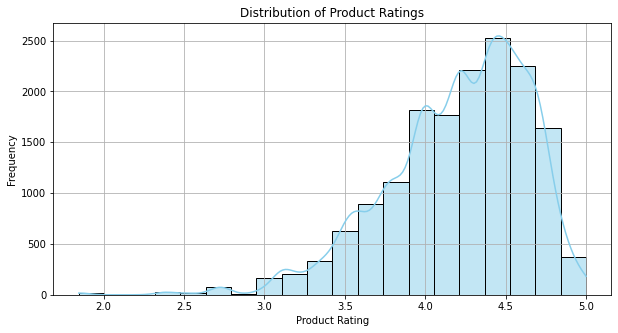

In [15]:
# Visualizing Distribution of Ratings
plt.figure(figsize=(10, 5))
sns.histplot(data['rating_x'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Product Ratings')
plt.xlabel('Product Rating')
plt.ylabel('Frequency')
plt.grid()
plt.show()

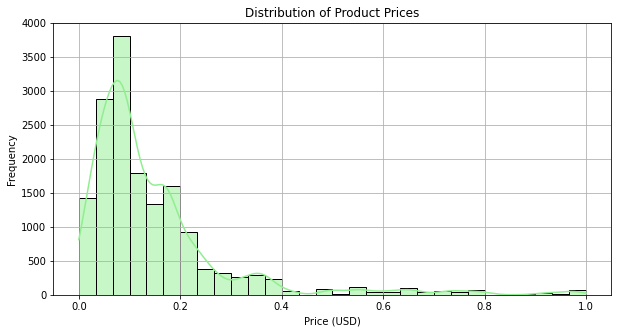

In [16]:
# Analyzing Product Price Distribution
plt.figure(figsize=(10, 5))
sns.histplot(data['price_usd'], bins=30, kde=True, color='lightgreen')
plt.title('Distribution of Product Prices')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

#### BIVARIATE ANALYSIS

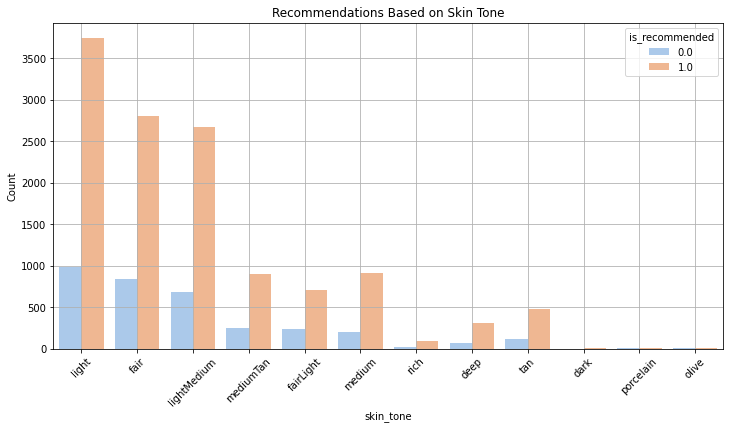

In [17]:
# Recommendations by Skin Tone
plt.figure(figsize=(12, 6))
# Using a single skin_tone column for visualization
sns.countplot(data=data, x='skin_tone', hue='is_recommended', palette='pastel')
plt.title('Recommendations Based on Skin Tone')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid()
plt.show()

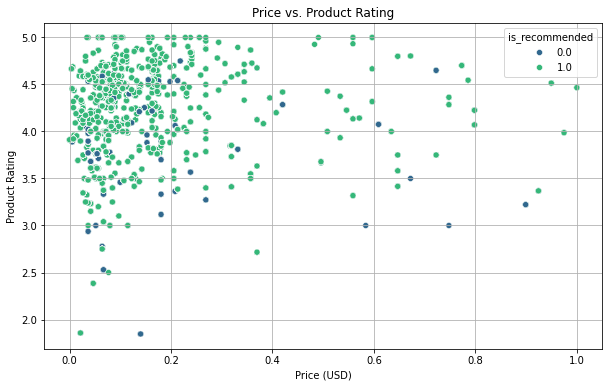

In [18]:
# Correlation between Ratings and Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='price_usd', y='rating_x', hue='is_recommended', palette='viridis')
plt.title('Price vs. Product Rating')
plt.xlabel('Price (USD)')
plt.ylabel('Product Rating')
plt.grid()
plt.show()

#### MULTIVARIATE ANALYSIS

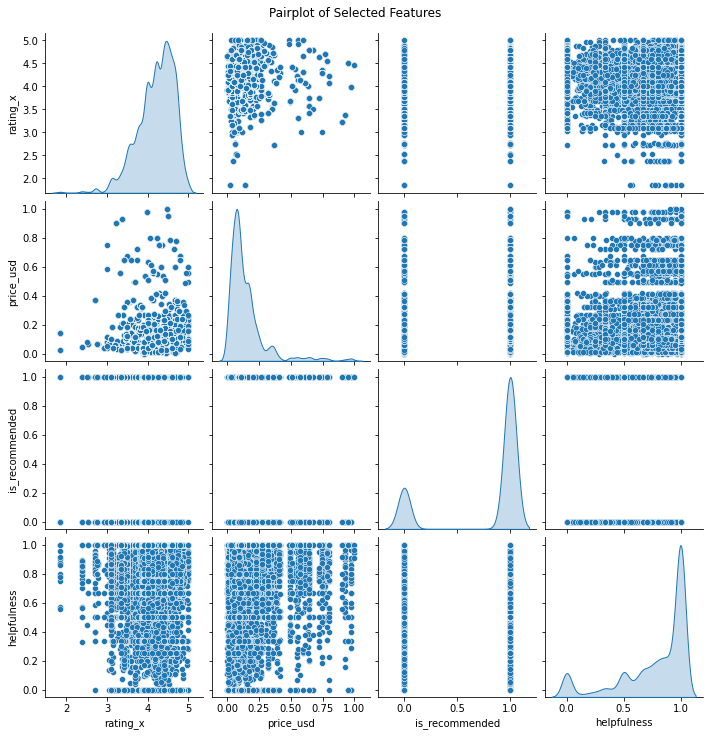

In [21]:
# Pairplot for Selected Features
selected_features = ['rating_x', 'price_usd', 'is_recommended', 'helpfulness']
sns.pairplot(data[selected_features], diag_kind='kde')
plt.suptitle('Pairplot of Selected Features', y=1.02)  # Adjust title position
plt.show()

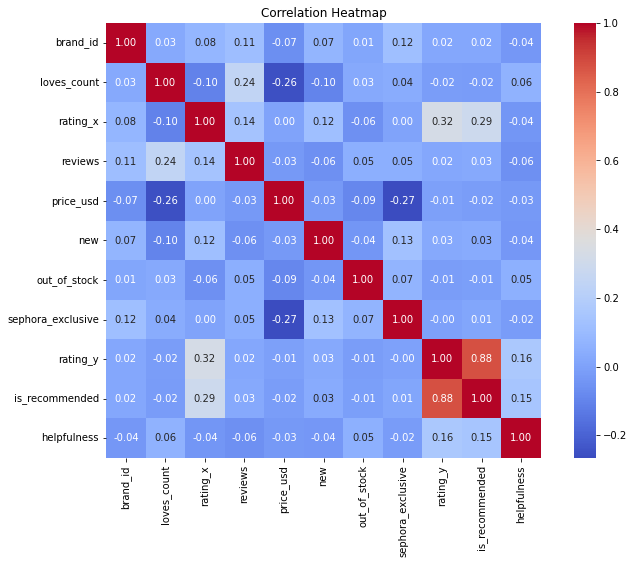

In [25]:
# Heatmap of Correlation Between Numeric Features
plt.figure(figsize=(12, 8))

# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Calculate correlation only on numeric columns
correlation = numeric_data.corr()

# Create the heatmap
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
### STEP 4: NLP

In [ ]:
### STEP 5: MODELING

In [ ]:
### STEP 6: FEATURE IMPORTANCE

In [ ]:
### STEP 7: SAVING MODELS FOR DEPLOYMENT

In [ ]:
### RECOMMENDATIONS